In [1]:
import pandas as pd
import numpy as np
import datetime
from filegenerators import *
pd.options.display.float_format = '{:.2e}'.format
from pathlib import Path
from CovCor_calc import OptimaMechtest, OptimaOutput, OptimaSensitivity
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
"""
If ic=0 => absolute sigma => dataPoint variablestd = small error
If ic!=0 rel sigma => common properties => new property value = ln((val/1.5)/(val*1.5))/4
"""
def splitSigmas(df, inputs, observables, must_be_zero):
    rel_sigmas = dict()
    abs_sigmas = dict()

    for index, row in df.iterrows():
        if row.species in inputs:
#        if row.species not in observables:
            continue
        if row.value in must_be_zero and row.species not in inputs:
            rel_sigmas[row.species] = 5e-14
        elif row.species not in inputs and row.species in observables:
            rel_sigmas[row.species] = ((row.value*1.5-row.value/2)/8)*1e-12
    return rel_sigmas

def makeBounds(df):
    bounds = dict()
    for index, row in df.iterrows():
        if row.value < 0.1:
            lb = 1e-14
            ub = 1e-13
        else:
            lb = (row.value/2)*1e-12
            ub = (row.value*1.5)*1e-12
        bounds[row.species] = [lb, ub]
    return bounds

def makeBounds2(df):
    bounds = dict()
    for index, row in df.iterrows():
        lb = (row.minconc)*1e-12
        ub = (row.maxconc)*1e-12
        bounds[row.species] = [lb, ub]
    return bounds 

In [3]:
def generate_opp_content(xml_folder: str, name: str, num_xml: int, mech_file: str = "7_Krisztian/mech/BCRN6.inp", 
                            yaml_file: str = "7_Krisztian/mech/BCRN6.yaml", time_limit: int = 50, thread_limit: int = 32,
                            settings_tag: str = "systems_biology", solver: str = "cantera", extension: str = ".xml") -> str:
        # Collect all matching XML files for this worksheet
        folder = Path(xml_folder)
        xml_files = sorted(f for f in folder.glob(f"*{name}*{extension}"))

        # Create MECHMOD section
        mechmod = f"""MECHMOD
    USE_NAME         BCRN6
    MECH_FILE        {mech_file}
    COMPILE_cantera  {yaml_file}
    END
    """

        # Create MECHTEST section
        mechtest = f"""MECHTEST
        MECHANISM  BCRN6
        TIME_LIMIT {time_limit}
        THREAD_LIMIT {thread_limit}
        SETTINGS_TAG {settings_tag}
        FALLBACK_TO_DEFAULT_SETTINGS

        SOLVER {solver}
        SAVE_STATES      CSV
    """

        # Add each XML file name
        for idx, xml in enumerate(xml_files):
            if idx < num_xml:
                mechtest += f"      NAME {xml.as_posix()}\n"

        mechtest += "END\n"

        return mechmod + "\n" + mechtest

In [4]:
df_species_ics = pd.read_excel('input_files/reactions_ics_finalised.xlsx', sheet_name='icranges')
df_species_ics['value'] = df_species_ics['value'].astype(float)

observables = []
for index, row in df_species_ics.iterrows():
    if row.value > 0:
        observables.append(row.species)
with open ('observables.txt', 'w') as f:
    for spec in observables:
        f.write(f"{spec}\n")
len(observables)

35

In [5]:
#inoputokat ki kell szedni
input_names =  ['nS', 'RAP', 'TG', 'dS', 'CCH', 'REF', 'Insulin', 'TG_SERCA', 'mTOR_RAP', 'casp', 'IP3R', 'Baxa', 'tBid']
must_be_zero = ['casp', 'Baxa', 'tBid', 'p53a', 'PUMA']
inputs = dict()
for i in input_names:
    inputs[i] = 0.0
inputs["REF"] = 1.0
inputs["Insulin"] = 1e-10

rel = splitSigmas(df_species_ics, input_names, observables, must_be_zero)
species = df_species_ics.species.to_list()
only_vars = list(set(species)-set(input_names))
no_inp_species = []

In [6]:
#dataPoints values
columns = list(set(observables)-set(input_names))
columns.sort()
columns.insert(0,'time')
time = np.linspace(0,24,25)

dataPoints = pd.DataFrame(columns=columns)
dataPoints['time'] = time*60

#Fill in the "theoretical" stacionary conentrations
for index, row in df_species_ics.iterrows():
    if row.species in dataPoints.columns:
        if row.value == 0:
            dataPoints.loc[:,row.species] = 1e-13
        else:
            dataPoints.loc[:,row.species] = row.value*1e-12
# dataPoints

In [7]:
df = pd.read_excel('input_files/reactions_ics_finalised.xlsx', sheet_name=None)

bounds = makeBounds(df["Sheet7"])
bounds2 = makeBounds2(df["icranges"])
print(bounds['mTORa'])
print(bounds2['mTORa'])

len(set(observables) - set(inputs.keys()))

[1.875e-10, 5.625e-10]
[1.875e-10, 7.5e-10]


34

In [8]:

# Directory to save files
output_directory = '/home/nvme/Opt/7_Krisztian/xml/Stac_corr_seeded'
output_directory2 = '/home/nvme/Opt/7_Krisztian/xml/Stac_corr2_seeded'

# Create the directory if it does not exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
if not os.path.exists(output_directory2):
    os.makedirs(output_directory2)

num_xml = 1000
#dataPoints['PKC'] = dataPoints['PKC'] * 0.1

np.random.seed(0)

for i in range(1, num_xml+1):
    file_index = i
    generate_file(file_index, output_directory, only_vars, inputs, bounds, dataPoints, rel)
    generate_file(file_index, output_directory2, only_vars, inputs, bounds2, dataPoints, rel)
print("job finished")
print(len(only_vars))
print(len(input_names))

job finished
67
13


In [ ]:
num_xmls = [25, 50, 100, 250, 500, 600, 700, 800, 900, 1000]   # max(num_xmls) <= num_xml kell
date = datetime.datetime.now()
opp_output_dir = "../1_mechtest"
old_opps = []
new_opps = []

for num in num_xmls:
    opp_content = generate_opp_content(output_directory, name='stac', num_xml=num)
    opp_content2 = generate_opp_content(output_directory2, name='stac', num_xml=num)
    
    opp_filename = f"{date.year}{date.month}{date.day}_BCRN_corr_{num}_old.opp" # Define output .opp file path
    opp_filename2 = f"{date.year}{date.month}{date.day}_BCRN_corr_{num}_new.opp" # Define output .opp file path

    old_opps.append(opp_filename)
    new_opps.append(opp_filename2)
    
    with open(os.path.join(opp_output_dir, opp_filename), "w") as f:
                f.write(opp_content)
    with open(os.path.join(opp_output_dir, opp_filename2), "w") as f:
                f.write(opp_content2)

In [13]:
from CovCor_calc import OptimaMechtest, OptimaOutput, OptimaSensitivity
new_opps

['2025524_BCRN_corr_25_new.opp',
 '2025524_BCRN_corr_50_new.opp',
 '2025524_BCRN_corr_100_new.opp',
 '2025524_BCRN_corr_250_new.opp',
 '2025524_BCRN_corr_500_new.opp',
 '2025524_BCRN_corr_750_new.opp',
 '2025524_BCRN_corr_1000_new.opp']

In [11]:
old_results: dict[int: OptimaMechtest] = {}
new_results: dict[int: OptimaMechtest] = {}

for idx, opp_name in enumerate(old_opps):
    old_results[num_xmls[idx]] = OptimaMechtest(opp_name)   # each result object mapped to the num. of xmls used to create them

for idx, opp_name2 in enumerate(new_opps):
    new_results[num_xmls[idx]] = OptimaMechtest(opp_name2)

In [31]:
def plot_corr_matrix(df_corr, title="", figsize=(12, 10), vmin=-1, vmax=1, fontsize=7):
    plt.figure(figsize=figsize)
    sns.heatmap(df_corr, 
                annot=False, 
                cmap='coolwarm', 
                center=0,
                vmin=vmin,
                vmax=vmax,
                xticklabels=True,
                yticklabels=True,
                square=True,
                linewidths=0.3,
                cbar_kws={"shrink": 0.8})
    plt.xticks(rotation=90, fontsize=fontsize)
    plt.yticks(rotation=0, fontsize=fontsize)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"{title}.pdf")
    plt.show()


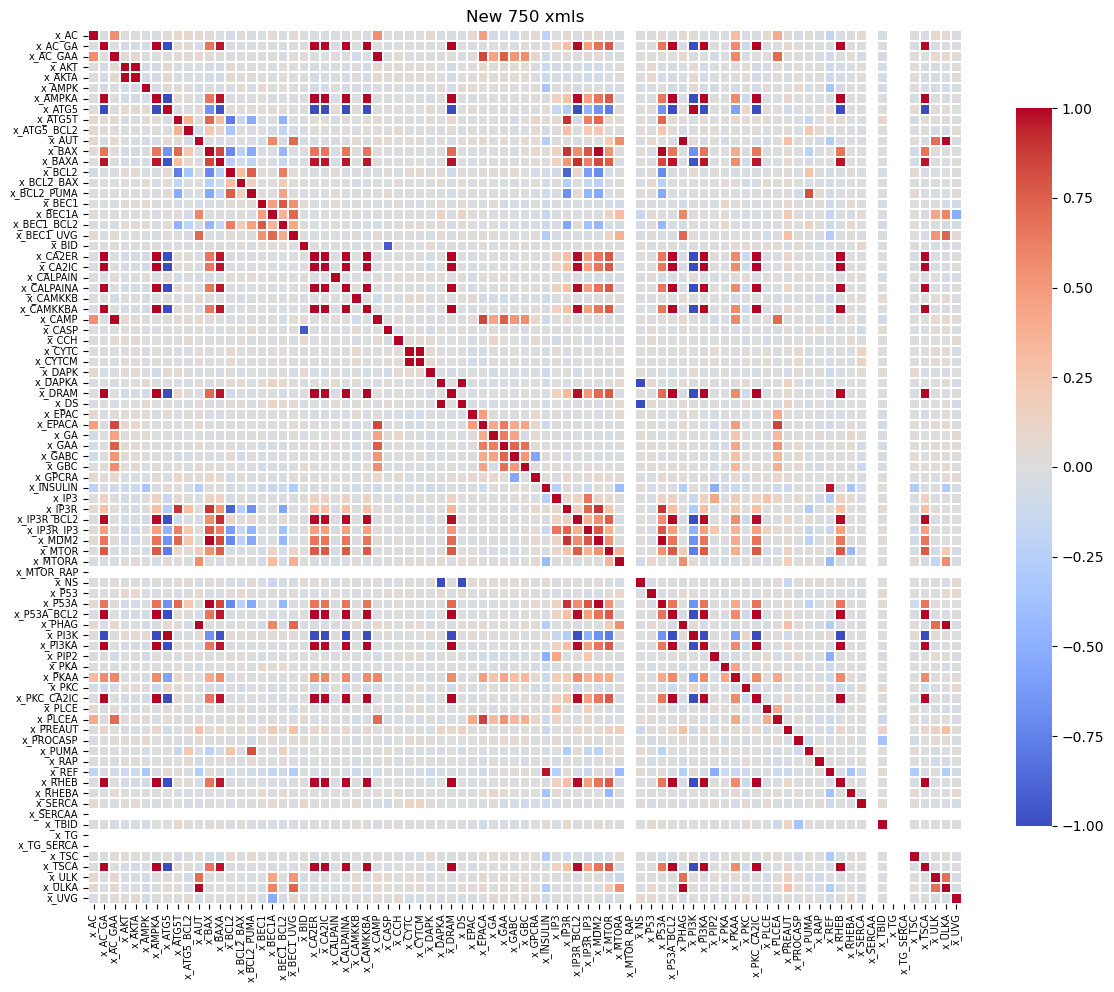

In [37]:
plot_corr_matrix(new_results[750].df_basal.corr(), "New 750 xmls")

In [11]:
print(f"Old sampling .opp filename: {opp_filename}\nNew sampling .opp filename: {opp_filename2}")

Old sampling .opp filename: 2025523_BCRN_corr_1000_old.opp
New sampling .opp filename: 2025523_BCRN_corr_1000_new.opp


In [ ]:
# Run
# bin/Release/OptimaPP 7_Krisztian/1_mechtest/2025523_BCRN_corr_100_old.opp      for old one
# bin/Release/OptimaPP 7_Krisztian/1_mechtest/2025523_BCRN_corr_100_new.opp      for new one

'MECHMOD\n    USE_NAME         BCRN6\n    MECH_FILE        7_Krisztian/mech/BCRN6.inp\n    COMPILE_cantera  7_Krisztian/mech/BCRN6.yaml\n    END\n    \nMECHTEST\n        MECHANISM  BCRN6\n        TIME_LIMIT 50\n        THREAD_LIMIT 32\n        SETTINGS_TAG systems_biology\n        FALLBACK_TO_DEFAULT_SETTINGS\n\n        SOLVER cantera\n        SAVE_STATES      CSV\n    END\n'